In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes
from tqdm import tqdm

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((331, 10), (111, 10), (331,), (111,))

In [3]:
def gb_predict(X, trees_list, coef_list, eta):
    
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])


In [4]:
def mse_err(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [5]:
def bias(y, z):
    return (y - z)

In [6]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in tqdm(range(n_trees)):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mse_err(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mse_err(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mse_err(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mse_err(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [65]:
params_grid = {
    'max_depth': [1, 3, 5],
    'n_trees': [1, 10, 50]
}
err_history_params = []

for max_depth in params_grid['max_depth']:
    err_by_max_depth = []
    
    for n_trees in params_grid['n_trees']:
        coefs = [1] * n_trees
        trees, train_errors, test_errors = gb_fit(n_trees=n_trees, 
                                                  max_depth=max_depth,
                                                  X_train=X_train,
                                                  X_test=X_test,
                                                  y_train=y_train,
                                                  y_test=y_test, 
                                                  coefs=coefs,
                                                  eta=0.01)
        err_by_max_depth.append(np.min(test_errors))
    err_history_params.append(err_by_max_depth)

100%|██████████| 50/50 [01:21<00:00,  1.62s/it]


In [66]:
result = pd.DataFrame(
    err_history_params,
    index=params_grid['n_trees'],
    columns=params_grid['max_depth'])

Text(51.0, 0.5, 'n_trees')

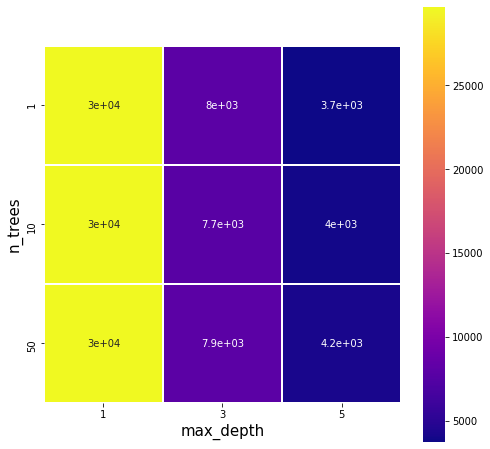

In [75]:
fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.heatmap(result,
            cmap='plasma',
            annot=True,
            fmt='.2g',
            linewidths=1,
            square=True,
            ax=axes)

axes.set_xlabel('max_depth', fontsize=15)
axes.set_ylabel('n_trees', fontsize=15)

Для этих данных и параметров обучения (eta=0.01, coef=1) чем больше глубина, тем меньше ошибка на тестовой выборке. Если глубина дерева не меняется, то количество деревьев практически не влияет на ошибку. Минимальная ошибка достигается при глубине 5 и одном дереве.